In [1]:
from rmp import RMPRoot, RMPTree, RMPNode, RMPLeaf_CLF
from rmp_leaf import NaiveCollisionAvoidance, CollisionAvoidance, GoalAttractorUni, Damper
from rmp_leaf import GoalAttractorUni_CLF
import numpy as np
from numpy.linalg import norm

from scipy.integrate import odeint
import matplotlib.pyplot as plt

from IPython.display import HTML
from rmp_util import obstacle, scene, policy_evaluator

# Play here

In [5]:
x_g = np.array([-1, 2.6])
x_o = np.array([0, 0])
x_o2 = np.array([0, 0])
x = np.array([2.5, -3.2])
x_dot = np.array([-1, 3])

test_scene = scene(goal=x_g, obstacle=[obstacle(x_o, 1)], x=x, x_dot=x_dot)

r = RMPRoot('Root')

Cave = CollisionAvoidance('collision_avoidance', r, obstacle=test_scene.obstacle[0], alpha=1e-5, eta=0)

NCave = NaiveCollisionAvoidance('naive_collision_avoidance', r, obstacle=test_scene.obstacle[0], alpha=0, eta=1e-2)

Gaoi = GoalAttractorUni('goal_attractor', r, test_scene.goal)

GaoiCLF = GoalAttractorUni_CLF('goal_attractor_clf', r, test_scene.goal, d=0.1, gain=10)


In [6]:
tree = RMPTree(root=r, nodes=[GaoiCLF, Cave])
pe = policy_evaluator(test_scene, tree, np.linspace(0,30,300), method='step')

/home/Cyan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [ ]:
#print('step cost', pe.step_cost())
fig, axes = plt.subplots(figsize=(5,5))
pe.plot(fig, axes)

In [15]:
ani = pe.video(fig, axes, frames=300, show_path=False)
HTML(ani.to_html5_video())

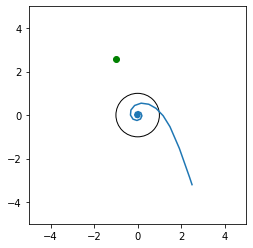

In [9]:
tree2 = RMPTree(r, [NCave])
pe2 = policy_evaluator(test_scene, tree2, np.linspace(0,30,300), method='ivp')
fig, axes = plt.subplots()
pe2.plot(fig, axes)

# Notes
- the robot may be struggled under the summation dynamics


### Matplot Lab

In [ ]:
fig, axes = plt.subplots(figsize=(10,10))

x = np.linspace(0, 2*np.pi, 100)
axes.plot(x, np.sin(x))
circle = plt.Circle((np.pi, 0), 0.5)
axes.add_artist(circle)
axes.set_aspect('equal')


In [ ]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme

set_nb_theme('grade3')